In [5]:
import matplotlib.pyplot as plt  # Used for plotting and visualizations
import pandas as pd  # Handles structured data (match events)
from mplsoccer import Sbopen, Pitch  # Sbopen loads StatsBomb data, Pitch is for visualizing the field
from sklearn.cluster import KMeans  # Used for clustering passes into groups
import numpy as np  # Supports numerical operations

In [6]:
parser = Sbopen()  # Initialize StatsBomb parser
match_id = 3869321  # Define the match ID to analyze (Netherlands vs Argentina)
events = parser.event(match_id)[0]  # Retrieve event data for the match (first DataFrame contains all events)


In [7]:
# Create a boolean mask to filter only passes made by Argentina
mask = (events.type_name == 'Pass') & (events.team_name == "Argentina")

# Select relevant columns for analysis
df_ar = events.loc[mask, ["x", 'y', 'end_x', 'end_y', 'player_name', "id", "type_name",
                          "outcome_name", "minute", 'second', "under_pressure", 'pass_cross']]



In [8]:
mask = ((df_ar.end_x >= 80) & (df_ar.x <= 60))  # Select passes that start in argentina's half and end in final third
transition = df_ar.loc[mask]  # Apply the filter to get progressive passes


In [9]:
df_pass = transition.copy()  # Make a copy of the filtered data

# Function to classify passes into left, center, or right corridors based on y-coordinates
def assign_corridor(y):
    if y < 26.67:
        return "right"  # Pass is on the right side
    elif y >= 26.67 and y <= 53.33:
        return "center"  # Pass is in the center
    else:
        return "left"  # Pass is on the left side

df_pass['corridor'] = df_pass['y'].apply(assign_corridor)  # Apply the function to categorize passes


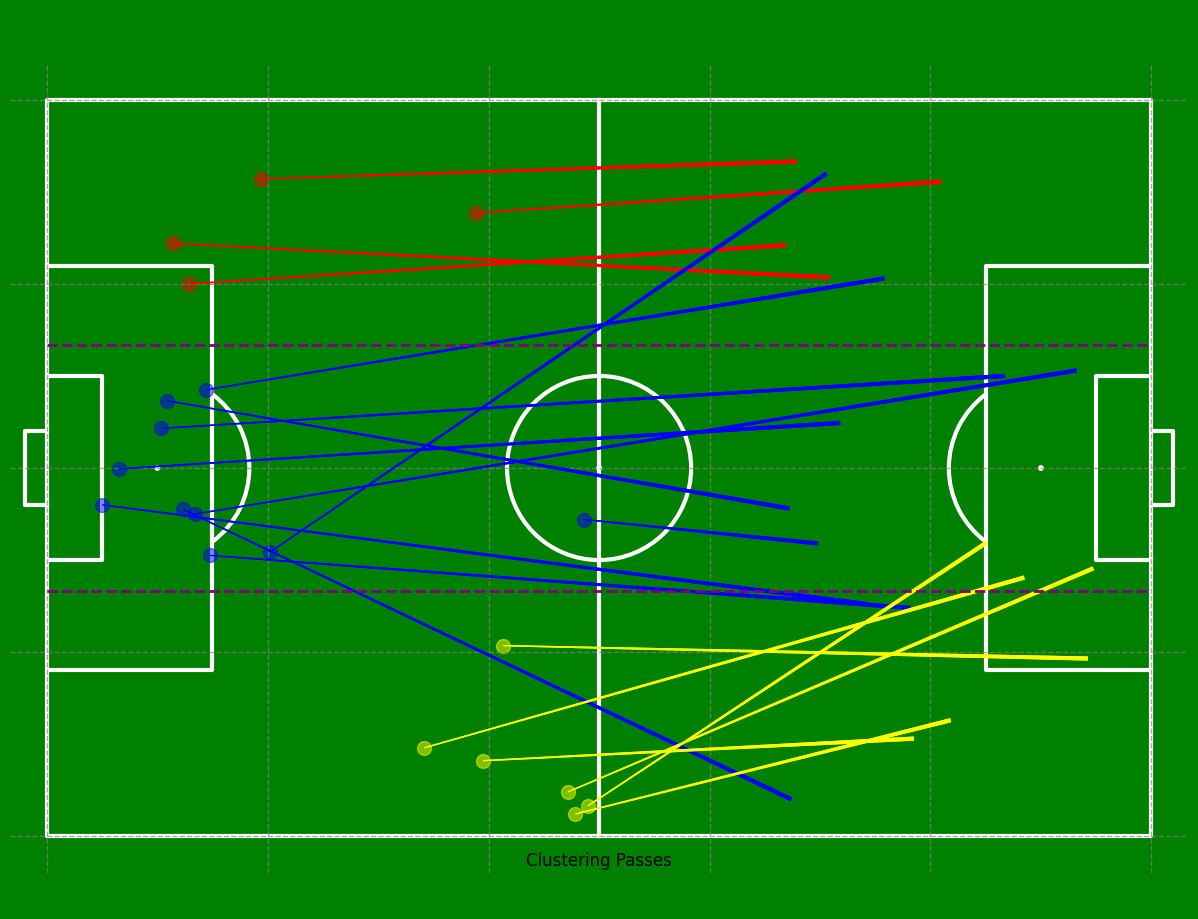

In [11]:
pitch = Pitch(line_color="white", pitch_color="green", linewidth=3, pitch_type='statsbomb',
              line_alpha=1, goal_alpha=1, goal_type='box')  # Define the pitch layout

# Create a figure with a pitch grid layout
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                      endnote_height=0.04, title_space=0, endnote_space=0)

fig.set_facecolor("green")  # Set the background color of the figure
corridor_colors = {'right': 'red', 'center': 'blue', 'left': 'yellow'}  # Define colors for each corridor


n_clusters = 3  # Define the number of clusters per corridor

# Loop through each corridor and apply clustering
for corridor, color in corridor_colors.items():
    # Select passes that belong to the current corridor
    corridor_data = df_pass[df_pass['corridor'] == corridor][['x', 'y', 'end_x', 'end_y']].dropna()

    if len(corridor_data) > n_clusters:  # Ensure there are enough data points for clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=100, n_init=10)  # Initialize KMeans
        kmeans.fit(corridor_data)  # Fit the model to the data

        # Assign cluster labels
        df_pass.loc[df_pass['corridor'] == corridor, 'cluster'] = kmeans.predict(corridor_data)

        # Plot passes, color-coded by corridor
        pitch.scatter(corridor_data['x'], corridor_data['y'], ax=ax['pitch'], 
                      color=color, alpha=0.5, s=100, label=f"Corridor {corridor}")
        
        # Draw pass lines
        pitch.lines(corridor_data['x'], corridor_data['y'],
                    corridor_data['end_x'], corridor_data['end_y'],
                    capstyle='butt',  # Cut-off the line at the end location.
                    linewidth=3, color=color, comet=True, ax=ax['pitch'])


pitch_length = 120  # Pitch length
pitch_width = 80  # Pitch width

# Define the boundaries of vertical corridors
corridor_lines = [26.67, 53.33]  # Y-axis values where corridors are separated

# Add a grid to the pitch
ax['pitch'].set_xticks(np.linspace(0, pitch_length, 6))  # Vertical lines (5 columns)
ax['pitch'].set_yticks(np.linspace(0, pitch_width, 5))  # Horizontal lines (4 rows)
ax['pitch'].grid(color="gray", linestyle="--", linewidth=1, alpha=0.7)  # Dashed grid lines

# Draw corridor boundary lines
for y in corridor_lines:
    ax['pitch'].hlines(y, xmin=0, xmax=pitch_length, color="purple", linestyle="--", linewidth=2)


plt.title("Clustering Passes", fontsize=12)  # Set the plot title

# Save the figure (fix file name issue)
plt.savefig("Clustering_Passes.png")  # Saves the image

